# High-Dimensional Bayesian Optimization with SAASBO

This tutorial shows how to use the Sparse Axis-Aligned Subspace Bayesian Optimization (SAASBO) method for high-dimensional Bayesian optimization [1]. SAASBO places strong priors on the inverse lengthscales to avoid overfitting in high-dimensional spaces. Specifically, SAASBO uses a hierarchical sparsity prior consisting of a global shrinkage parameter $\tau \sim \mathcal{HC}(\beta)$ and inverse lengthscales $\rho_d \sim \mathcal{HC}(\tau)$ for $d=1, ..., D$, where $\mathcal{HC}$ is the half-Cauchy distribution. While half-Cauchy priors favor values near zero they also have heavy tails, which allows the inverse lengthscales of the most important parameters to escape zero. To do inference in the SAAS model we use Hamiltonian Monte Carlo (HMC) as we found that to outperform MAP inference.

We find that SAASBO performs well on problems with hundreds of dimensions. As we rely on HMC and in particular the No-U-Turn-Sampler (NUTS) for inference, the overhead of SAASBO scales cubically with the number of datapoints. Depending on the problem, using more than $100$ evaluations may not be feasible as SAASBO is designed for problems with a limited evaluation budget.

[1] D. Eriksson, M. Jankowiak. High-Dimensional Bayesian Optimization with Sparse Axis-Aligned Subspaces. Proceedings of the Thirty-Seventh Conference on Uncertainty in Artificial Intelligence, 2021.

In [1]:
import os

from ax import Data, Experiment, ParameterType, RangeParameter, SearchSpace
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.runners.synthetic import SyntheticRunner

In [2]:
SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [3]:
import torch


torch.manual_seed(12345)  # To always get the same Sobol points
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

## Setup search space and metric
In this simple experiment we use the Branin function embedded in a 50-dimensional space. Additional resources:
- To set up a custom metric for your problem, refer to the dedicated section of the Developer API tutorial: https://ax.dev/tutorials/gpei_hartmann_developer.html#8.-Defining-custom-metrics.
- To avoid needing to setup up custom metrics by Ax Service API: https://ax.dev/tutorials/gpei_hartmann_service.html.

In [4]:
from ax.core.metric import Metric
from ax.core.objective import Objective
from ax.core.optimization_config import OptimizationConfig
from ax.metrics.branin import BraninMetric


search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name=f"x{i}", parameter_type=ParameterType.FLOAT, lower=-5.0, upper=10.0
        )
        for i in range(25)
    ]
    + [
        RangeParameter(
            name=f"x{i + 25}",
            parameter_type=ParameterType.FLOAT,
            lower=0.0,
            upper=15.0,
        )
        for i in range(25)
    ]
)

optimization_config = OptimizationConfig(
    objective=Objective(
        metric=BraninMetric(
            name="objective",
            param_names=["x19", "x44"],
            noise_sd=0.0,  # Set noise_sd=None if you want to learn the noise, otherwise it defaults to 1e-6
        ),
        minimize=True,
    )
)

## Run benchmark

In [5]:
N_INIT = 10
BATCH_SIZE = 3

if SMOKE_TEST:
    N_BATCHES = 1
else:
    N_BATCHES = 10

print(f"Doing {N_INIT + N_BATCHES * BATCH_SIZE} evaluations")

Doing 40 evaluations


In [6]:
# Experiment
experiment = Experiment(
    name="saasbo_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=SyntheticRunner(),
)

In [7]:
# Initial Sobol points
sobol = Models.SOBOL(search_space=experiment.search_space)
for _ in range(N_INIT):
    experiment.new_trial(sobol.gen(1)).run()

In [8]:
%%time
# Run SAASBO
data = experiment.fetch_data()
for i in range(N_BATCHES):
    model = Models.FULLYBAYESIAN(
        experiment=experiment,
        data=data,
        num_samples=256,  # Increasing this may result in better model fits
        warmup_steps=512,  # Increasing this may result in better model fits
        gp_kernel="rbf",  # "rbf" is the default in the paper, but we also support "matern"
        torch_device=tkwargs["device"],
        torch_dtype=tkwargs["dtype"],
        verbose=False,  # Set to True to print stats from MCMC
        disable_progbar=True,  # Set to False to print a progress bar from MCMC
    )
    generator_run = model.gen(BATCH_SIZE)
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()
    data = Data.from_multiple_data([data, trial.fetch_data()])

    new_value = trial.fetch_data().df["mean"].min()
    print(
        f"Iteration: {i}, Best in iteration {new_value:.3f}, Best so far: {data.df['mean'].min():.3f}"
    )

Iteration: 0, Best in iteration 308.129, Best so far: 9.413


Iteration: 1, Best in iteration 2.156, Best so far: 2.156


Iteration: 2, Best in iteration 4.359, Best so far: 2.156


Iteration: 3, Best in iteration 10.961, Best so far: 2.156


Iteration: 4, Best in iteration 17.508, Best so far: 2.156


Iteration: 5, Best in iteration 0.564, Best so far: 0.564


Iteration: 6, Best in iteration 0.510, Best so far: 0.510


Iteration: 7, Best in iteration 0.468, Best so far: 0.468


Iteration: 8, Best in iteration 0.425, Best so far: 0.425


Iteration: 9, Best in iteration 8.909, Best so far: 0.425
CPU times: user 3h 3min 34s, sys: 7min 15s, total: 3h 10min 49s
Wall time: 31min 23s


## Plot results
SAASBO is able to find a solution close to the global optimal value of 0.398

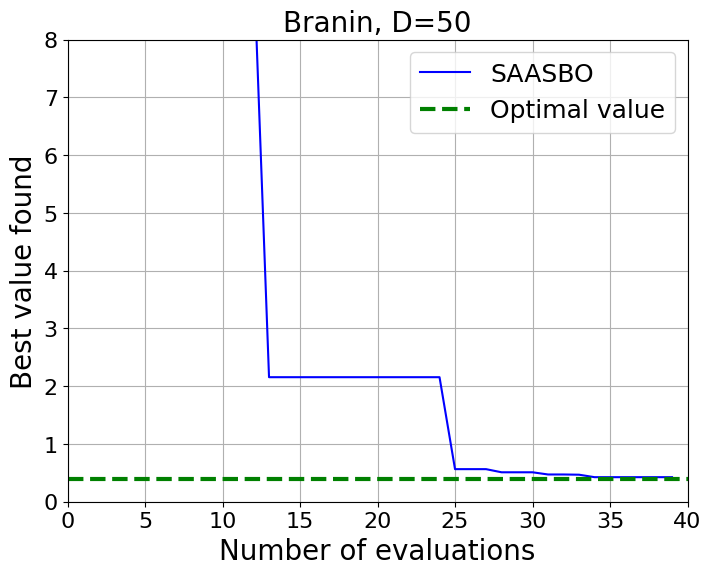

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
matplotlib.rcParams.update({"font.size": 16})


fig, ax = plt.subplots(figsize=(8, 6))
res_saasbo = data.df["mean"]
ax.plot(np.minimum.accumulate(res_saasbo), color="b", label="SAASBO")
ax.plot([0, len(res_saasbo)], [0.398, 0.398], "--", c="g", lw=3, label="Optimal value")
ax.grid(True)
ax.set_title("Branin, D=50", fontsize=20)
ax.set_xlabel("Number of evaluations", fontsize=20)
ax.set_xlim([0, len(res_saasbo)])
ax.set_ylabel("Best value found", fontsize=20)
ax.set_ylim([0, 8])
ax.legend(fontsize=18)
plt.show()

## SAAS model fit

We fit a SAAS model with the same settings as above

In [10]:
model = Models.FULLYBAYESIAN(
    experiment=experiment,
    data=data,
    use_saas=True,
    num_samples=256,
    warmup_steps=512,
    gp_kernel="rbf",
    torch_dtype=tkwargs["dtype"],
    torch_device=tkwargs["device"],
    disable_progbar=False,
    verbose=False,
)

Warmup:   0%|                                                                                                                                                                                                                         | 0/768 [00:00, ?it/s]

Warmup:   0%|                                            | 1/768 [00:00,  7.81it/s, step size=1.39e+00, acc. prob=0.858]                                                                                                                                    

Warmup:   1%|▏                                           | 4/768 [00:00,  9.53it/s, step size=8.06e-02, acc. prob=0.560]

Warmup:   1%|▎                                           | 5/768 [00:00,  7.41it/s, step size=1.25e-01, acc. prob=0.646]

Warmup:   1%|▎                                           | 6/768 [00:00,  6.27it/s, step size=1.74e-01, acc. prob=0.693]

Warmup:   1%|▍                                           | 7/768 [00:00,  6.96it/s, step size=3.09e-01, acc. prob=0.736]

Warmup:   1%|▌                                          | 10/768 [00:01,  8.69it/s, step size=6.52e-02, acc. prob=0.707]

Warmup:   1%|▌                                          | 11/768 [00:01,  7.30it/s, step size=1.22e-01, acc. prob=0.733]

Warmup:   2%|▋                                          | 12/768 [00:01,  6.23it/s, step size=2.14e-01, acc. prob=0.753]

Warmup:   2%|▊                                          | 14/768 [00:01,  6.55it/s, step size=1.03e-01, acc. prob=0.743]

Warmup:   2%|▊                                          | 15/768 [00:02,  6.41it/s, step size=1.24e-01, acc. prob=0.750]

Warmup:   2%|▉                                          | 17/768 [00:02,  7.58it/s, step size=3.25e-02, acc. prob=0.730]

Warmup:   2%|█                                          | 18/768 [00:02,  6.91it/s, step size=6.13e-02, acc. prob=0.745]

Warmup:   2%|█                                          | 19/768 [00:02,  6.44it/s, step size=1.11e-01, acc. prob=0.758]

Warmup:   3%|█▏                                         | 21/768 [00:03,  6.57it/s, step size=1.07e-01, acc. prob=0.760]

Warmup:   3%|█▎                                         | 23/768 [00:03,  6.75it/s, step size=3.24e-02, acc. prob=0.745]

Warmup:   3%|█▎                                         | 24/768 [00:03,  6.18it/s, step size=5.95e-02, acc. prob=0.756]

Warmup:   3%|█▍                                         | 25/768 [00:03,  5.75it/s, step size=8.29e-02, acc. prob=0.762]

Warmup:   3%|█▍                                         | 26/768 [00:03,  5.42it/s, step size=4.10e-02, acc. prob=0.754]

Warmup:   4%|█▌                                         | 27/768 [00:04,  5.33it/s, step size=6.92e-02, acc. prob=0.762]

Warmup:   4%|█▌                                         | 28/768 [00:04,  5.29it/s, step size=1.13e-01, acc. prob=0.769]

Warmup:   4%|█▌                                         | 29/768 [00:04,  6.08it/s, step size=1.47e-02, acc. prob=0.745]

Warmup:   4%|█▋                                         | 30/768 [00:04,  5.77it/s, step size=2.64e-02, acc. prob=0.753]

Warmup:   4%|█▋                                         | 31/768 [00:04,  5.59it/s, step size=4.61e-02, acc. prob=0.761]

Warmup:   4%|█▊                                         | 32/768 [00:05,  5.46it/s, step size=4.17e-02, acc. prob=0.761]

Warmup:   4%|█▊                                         | 33/768 [00:05,  5.40it/s, step size=7.26e-02, acc. prob=0.768]

Warmup:   4%|█▉                                         | 34/768 [00:05,  5.32it/s, step size=3.26e-02, acc. prob=0.760]

Warmup:   5%|█▉                                         | 35/768 [00:05,  5.31it/s, step size=5.67e-02, acc. prob=0.766]

Warmup:   5%|██                                         | 36/768 [00:05,  5.31it/s, step size=9.40e-02, acc. prob=0.772]

Warmup:   5%|██▏                                        | 38/768 [00:06,  6.08it/s, step size=2.74e-02, acc. prob=0.761]

Warmup:   5%|██▏                                        | 39/768 [00:06,  5.88it/s, step size=4.63e-02, acc. prob=0.767]

Warmup:   5%|██▏                                        | 40/768 [00:06,  5.69it/s, step size=6.83e-02, acc. prob=0.771]

Warmup:   5%|██▎                                        | 41/768 [00:06,  5.56it/s, step size=9.88e-02, acc. prob=0.775]

Warmup:   6%|██▍                                        | 43/768 [00:06,  6.58it/s, step size=2.54e-02, acc. prob=0.763]

Warmup:   6%|██▍                                        | 44/768 [00:07,  6.14it/s, step size=4.01e-02, acc. prob=0.768]

Warmup:   6%|██▌                                        | 45/768 [00:07,  5.63it/s, step size=6.69e-02, acc. prob=0.773]

Warmup:   6%|██▌                                        | 46/768 [00:07,  5.33it/s, step size=1.17e-02, acc. prob=0.758]

Warmup:   6%|██▋                                        | 47/768 [00:07,  5.15it/s, step size=1.94e-02, acc. prob=0.763]

Warmup:   6%|██▋                                        | 48/768 [00:07,  5.12it/s, step size=3.20e-02, acc. prob=0.768]

Warmup:   6%|██▋                                        | 49/768 [00:08,  4.91it/s, step size=5.22e-02, acc. prob=0.773]

Warmup:   7%|██▊                                        | 50/768 [00:08,  4.94it/s, step size=8.21e-02, acc. prob=0.777]

Warmup:   7%|██▊                                        | 51/768 [00:08,  5.31it/s, step size=2.01e-02, acc. prob=0.765]

Warmup:   7%|██▉                                        | 52/768 [00:08,  5.21it/s, step size=3.29e-02, acc. prob=0.770]

Warmup:   7%|██▉                                        | 53/768 [00:08,  5.10it/s, step size=5.34e-02, acc. prob=0.774]

Warmup:   7%|███                                        | 54/768 [00:09,  5.07it/s, step size=7.30e-02, acc. prob=0.777]

Warmup:   7%|███                                        | 55/768 [00:09,  5.88it/s, step size=2.92e-02, acc. prob=0.770]

Warmup:   7%|███▏                                       | 56/768 [00:09,  5.67it/s, step size=4.71e-02, acc. prob=0.774]

Warmup:   7%|███▏                                       | 57/768 [00:09,  5.56it/s, step size=7.16e-02, acc. prob=0.778]

Warmup:   8%|███▏                                       | 58/768 [00:09,  6.14it/s, step size=1.81e-02, acc. prob=0.767]

Warmup:   8%|███▎                                       | 59/768 [00:09,  5.85it/s, step size=2.84e-02, acc. prob=0.771]

Warmup:   8%|███▎                                       | 60/768 [00:10,  5.63it/s, step size=4.04e-02, acc. prob=0.774]

Warmup:   8%|███▍                                       | 61/768 [00:10,  5.38it/s, step size=5.97e-02, acc. prob=0.777]

Warmup:   8%|███▍                                       | 62/768 [00:10,  4.58it/s, step size=9.34e-02, acc. prob=0.781]

Warmup:   8%|███▌                                       | 63/768 [00:10,  5.28it/s, step size=5.86e-02, acc. prob=0.778]

Warmup:   8%|███▌                                       | 64/768 [00:10,  4.77it/s, step size=8.17e-02, acc. prob=0.780]

Warmup:   8%|███▋                                       | 65/768 [00:11,  5.35it/s, step size=2.53e-02, acc. prob=0.772]

Warmup:   9%|███▋                                       | 66/768 [00:11,  4.87it/s, step size=3.94e-02, acc. prob=0.775]

Warmup:   9%|███▊                                       | 67/768 [00:11,  4.51it/s, step size=3.79e-02, acc. prob=0.775]

Warmup:   9%|███▊                                       | 68/768 [00:11,  4.26it/s, step size=5.75e-02, acc. prob=0.779]

Warmup:   9%|███▊                                       | 69/768 [00:12,  4.31it/s, step size=7.04e-02, acc. prob=0.780]

Warmup:   9%|███▉                                       | 70/768 [00:12,  4.21it/s, step size=1.08e-01, acc. prob=0.783]

Warmup:   9%|████                                       | 72/768 [00:12,  5.25it/s, step size=3.24e-02, acc. prob=0.775]

Warmup:  10%|████                                       | 73/768 [00:12,  5.01it/s, step size=3.62e-02, acc. prob=0.776]

Warmup:  10%|████▏                                      | 74/768 [00:13,  4.85it/s, step size=5.17e-02, acc. prob=0.779]

Warmup:  10%|████▏                                      | 75/768 [00:13,  4.87it/s, step size=4.52e-02, acc. prob=0.778]

Warmup:  10%|████▎                                      | 76/768 [00:13,  4.87it/s, step size=4.41e-02, acc. prob=0.778]

Warmup:  10%|████▎                                      | 77/768 [00:13,  4.95it/s, step size=6.66e-02, acc. prob=0.781]

Warmup:  10%|████▎                                      | 78/768 [00:13,  5.60it/s, step size=2.13e-02, acc. prob=0.774]

Warmup:  10%|████▍                                      | 79/768 [00:14,  5.18it/s, step size=3.23e-02, acc. prob=0.777]

Warmup:  10%|████▍                                      | 80/768 [00:14,  5.13it/s, step size=4.89e-02, acc. prob=0.780]

Warmup:  11%|████▌                                      | 81/768 [00:14,  4.14it/s, step size=4.23e-02, acc. prob=0.779]

Warmup:  11%|████▌                                      | 82/768 [00:14,  4.05it/s, step size=6.28e-02, acc. prob=0.781]

Warmup:  11%|████▋                                      | 83/768 [00:15,  4.07it/s, step size=8.16e-02, acc. prob=0.783]

Warmup:  11%|████▋                                      | 84/768 [00:15,  4.04it/s, step size=2.83e-02, acc. prob=0.777]

Warmup:  11%|████▊                                      | 85/768 [00:15,  3.57it/s, step size=4.24e-02, acc. prob=0.779]

Warmup:  11%|████▊                                      | 86/768 [00:15,  3.83it/s, step size=5.06e-02, acc. prob=0.781]

Warmup:  11%|████▊                                      | 87/768 [00:16,  4.00it/s, step size=7.51e-02, acc. prob=0.783]

Warmup:  11%|████▉                                      | 88/768 [00:16,  3.93it/s, step size=7.56e-02, acc. prob=0.783]

Warmup:  12%|████▉                                      | 89/768 [00:16,  4.34it/s, step size=3.66e-02, acc. prob=0.779]

Warmup:  12%|█████                                      | 90/768 [00:16,  3.76it/s, step size=5.30e-02, acc. prob=0.781]

Warmup:  12%|█████                                      | 91/768 [00:17,  3.71it/s, step size=7.52e-02, acc. prob=0.784]

Warmup:  12%|█████▏                                     | 92/768 [00:17,  3.92it/s, step size=1.10e-01, acc. prob=0.786]

Warmup:  12%|█████▎                                     | 94/768 [00:17,  4.81it/s, step size=4.38e-02, acc. prob=0.781]

Warmup:  12%|█████▎                                     | 95/768 [00:17,  4.74it/s, step size=5.58e-02, acc. prob=0.782]

Warmup:  12%|█████▍                                     | 96/768 [00:18,  4.45it/s, step size=7.88e-02, acc. prob=0.784]

Warmup:  13%|█████▍                                     | 98/768 [00:18,  5.00it/s, step size=4.21e-02, acc. prob=0.781]

Warmup:  13%|█████▌                                     | 99/768 [00:18,  4.46it/s, step size=9.75e-01, acc. prob=0.783]

Warmup:  13%|█████▌                                    | 102/768 [00:19,  6.45it/s, step size=2.32e-01, acc. prob=0.770]

Warmup:  13%|█████▋                                    | 103/768 [00:19,  5.73it/s, step size=2.48e-01, acc. prob=0.771]

Warmup:  14%|█████▋                                    | 104/768 [00:19,  5.39it/s, step size=1.74e-01, acc. prob=0.771]

Warmup:  14%|█████▋                                    | 105/768 [00:19,  5.11it/s, step size=2.65e-01, acc. prob=0.773]

Warmup:  14%|█████▊                                    | 106/768 [00:20,  4.89it/s, step size=3.83e-01, acc. prob=0.775]

Warmup:  14%|█████▊                                    | 107/768 [00:20,  4.96it/s, step size=3.77e-02, acc. prob=0.768]

Warmup:  14%|█████▉                                    | 108/768 [00:20,  4.88it/s, step size=6.91e-02, acc. prob=0.770]

Warmup:  14%|█████▉                                    | 109/768 [00:20,  4.70it/s, step size=1.28e-01, acc. prob=0.772]

Warmup:  14%|██████                                    | 110/768 [00:20,  4.62it/s, step size=2.38e-01, acc. prob=0.774]

Warmup:  14%|██████                                    | 111/768 [00:21,  4.68it/s, step size=3.66e-01, acc. prob=0.776]

Warmup:  15%|██████▏                                   | 112/768 [00:21,  4.70it/s, step size=2.88e-01, acc. prob=0.775]

Warmup:  15%|██████▏                                   | 113/768 [00:21,  4.69it/s, step size=3.52e-01, acc. prob=0.776]

Warmup:  15%|██████▏                                   | 114/768 [00:21,  4.63it/s, step size=6.57e-01, acc. prob=0.778]

Warmup:  15%|██████▎                                   | 116/768 [00:21,  5.87it/s, step size=1.09e-01, acc. prob=0.773]

Warmup:  15%|██████▍                                   | 117/768 [00:22,  5.44it/s, step size=2.07e-01, acc. prob=0.775]

Warmup:  15%|██████▍                                   | 118/768 [00:22,  5.26it/s, step size=3.84e-01, acc. prob=0.777]

Warmup:  15%|██████▌                                   | 119/768 [00:22,  5.16it/s, step size=1.37e-01, acc. prob=0.774]

Warmup:  16%|██████▌                                   | 120/768 [00:22,  4.84it/s, step size=1.69e-01, acc. prob=0.775]

Warmup:  16%|██████▌                                   | 121/768 [00:23,  4.82it/s, step size=2.85e-01, acc. prob=0.776]

Warmup:  16%|██████▋                                   | 122/768 [00:23,  4.84it/s, step size=2.34e-01, acc. prob=0.776]

Warmup:  16%|██████▋                                   | 123/768 [00:23,  4.90it/s, step size=4.17e-01, acc. prob=0.778]

Warmup:  16%|██████▊                                   | 124/768 [00:23,  4.94it/s, step size=2.45e-01, acc. prob=0.776]

Warmup:  16%|██████▊                                   | 125/768 [00:23,  4.95it/s, step size=7.26e-02, acc. prob=0.773]

Warmup:  16%|██████▉                                   | 126/768 [00:24,  4.98it/s, step size=1.32e-01, acc. prob=0.775]

Warmup:  17%|██████▉                                   | 127/768 [00:24,  5.00it/s, step size=2.40e-01, acc. prob=0.776]

Warmup:  17%|███████                                   | 128/768 [00:24,  4.90it/s, step size=2.98e-01, acc. prob=0.777]

Warmup:  17%|███████                                   | 129/768 [00:24,  4.90it/s, step size=1.67e-01, acc. prob=0.776]

Warmup:  17%|███████                                   | 130/768 [00:24,  4.72it/s, step size=2.80e-01, acc. prob=0.777]

Warmup:  17%|███████▏                                  | 131/768 [00:25,  4.78it/s, step size=3.29e-01, acc. prob=0.778]

Warmup:  17%|███████▏                                  | 132/768 [00:25,  4.85it/s, step size=2.78e-01, acc. prob=0.777]

Warmup:  17%|███████▎                                  | 133/768 [00:25,  4.77it/s, step size=3.86e-01, acc. prob=0.778]

Warmup:  17%|███████▎                                  | 134/768 [00:25,  4.86it/s, step size=2.16e-01, acc. prob=0.777]

Warmup:  18%|███████▍                                  | 135/768 [00:25,  4.79it/s, step size=2.55e-01, acc. prob=0.777]

Warmup:  18%|███████▍                                  | 136/768 [00:26,  4.86it/s, step size=4.22e-01, acc. prob=0.779]

Warmup:  18%|███████▍                                  | 137/768 [00:26,  4.92it/s, step size=5.62e-02, acc. prob=0.773]

Warmup:  18%|███████▌                                  | 138/768 [00:26,  4.93it/s, step size=9.32e-02, acc. prob=0.775]

Warmup:  18%|███████▌                                  | 139/768 [00:26,  4.98it/s, step size=1.59e-01, acc. prob=0.776]

Warmup:  18%|███████▋                                  | 140/768 [00:26,  5.01it/s, step size=2.65e-01, acc. prob=0.778]

Warmup:  18%|███████▋                                  | 141/768 [00:27,  5.03it/s, step size=4.35e-01, acc. prob=0.779]

Warmup:  18%|███████▊                                  | 142/768 [00:27,  5.05it/s, step size=5.03e-01, acc. prob=0.780]

Warmup:  19%|███████▊                                  | 143/768 [00:27,  5.06it/s, step size=7.22e-02, acc. prob=0.774]

Warmup:  19%|███████▉                                  | 144/768 [00:27,  5.06it/s, step size=1.19e-01, acc. prob=0.776]

Warmup:  19%|███████▉                                  | 145/768 [00:27,  4.91it/s, step size=1.92e-01, acc. prob=0.777]

Warmup:  19%|███████▉                                  | 146/768 [00:28,  4.89it/s, step size=3.09e-01, acc. prob=0.779]

Warmup:  19%|████████                                  | 147/768 [00:28,  4.86it/s, step size=1.60e-01, acc. prob=0.777]

Warmup:  19%|████████                                  | 148/768 [00:28,  4.92it/s, step size=2.32e-01, acc. prob=0.778]

Warmup:  19%|████████▏                                 | 149/768 [00:28,  4.80it/s, step size=1.11e+00, acc. prob=0.779]

Warmup:  20%|████████▎                                 | 152/768 [00:28,  7.48it/s, step size=3.85e-01, acc. prob=0.771]

Warmup:  20%|████████▎                                 | 153/768 [00:29,  6.78it/s, step size=5.28e-01, acc. prob=0.772]

Warmup:  20%|████████▍                                 | 154/768 [00:29,  6.28it/s, step size=1.23e-01, acc. prob=0.770]

Warmup:  20%|████████▍                                 | 155/768 [00:29,  5.89it/s, step size=2.01e-01, acc. prob=0.771]

Warmup:  20%|████████▌                                 | 156/768 [00:29,  5.65it/s, step size=3.17e-01, acc. prob=0.772]

Warmup:  20%|████████▌                                 | 157/768 [00:29,  5.48it/s, step size=4.00e-01, acc. prob=0.773]

Warmup:  21%|████████▋                                 | 158/768 [00:30,  5.36it/s, step size=7.09e-01, acc. prob=0.774]

Warmup:  21%|████████▋                                 | 159/768 [00:30,  5.26it/s, step size=1.64e-01, acc. prob=0.772]

Warmup:  21%|████████▊                                 | 160/768 [00:30,  5.19it/s, step size=3.07e-01, acc. prob=0.773]

Warmup:  21%|████████▊                                 | 161/768 [00:30,  5.15it/s, step size=2.48e-01, acc. prob=0.773]

Warmup:  21%|████████▊                                 | 162/768 [00:30,  5.13it/s, step size=4.49e-01, acc. prob=0.774]

Warmup:  21%|████████▉                                 | 163/768 [00:31,  5.07it/s, step size=6.18e-01, acc. prob=0.775]

Warmup:  21%|████████▉                                 | 164/768 [00:31,  5.04it/s, step size=3.28e-01, acc. prob=0.774]

Warmup:  21%|█████████                                 | 165/768 [00:31,  5.06it/s, step size=4.96e-01, acc. prob=0.775]

Warmup:  22%|█████████                                 | 166/768 [00:31,  5.08it/s, step size=9.30e-01, acc. prob=0.776]

Warmup:  22%|█████████▏                                | 167/768 [00:31,  5.05it/s, step size=9.85e-02, acc. prob=0.772]

Warmup:  22%|█████████▏                                | 168/768 [00:32,  5.07it/s, step size=1.85e-01, acc. prob=0.773]

Warmup:  22%|█████████▏                                | 169/768 [00:32,  4.84it/s, step size=3.45e-01, acc. prob=0.774]

Warmup:  22%|█████████▎                                | 170/768 [00:32,  4.85it/s, step size=6.19e-01, acc. prob=0.776]

Warmup:  22%|█████████▎                                | 171/768 [00:32,  4.82it/s, step size=8.14e-01, acc. prob=0.776]

Warmup:  22%|█████████▍                                | 172/768 [00:33,  4.86it/s, step size=5.61e-01, acc. prob=0.776]

Warmup:  23%|█████████▍                                | 173/768 [00:33,  4.75it/s, step size=5.51e-01, acc. prob=0.776]

Warmup:  23%|█████████▌                                | 174/768 [00:33,  4.73it/s, step size=8.27e-01, acc. prob=0.777]

Warmup:  23%|█████████▌                                | 175/768 [00:33,  4.70it/s, step size=3.74e-01, acc. prob=0.775]

Warmup:  23%|█████████▋                                | 176/768 [00:33,  4.72it/s, step size=6.61e-01, acc. prob=0.776]

Warmup:  23%|█████████▋                                | 177/768 [00:34,  4.73it/s, step size=9.92e-01, acc. prob=0.777]

Warmup:  23%|█████████▋                                | 178/768 [00:34,  4.76it/s, step size=1.15e-01, acc. prob=0.773]

Warmup:  23%|█████████▊                                | 179/768 [00:34,  4.85it/s, step size=2.04e-01, acc. prob=0.774]

Warmup:  23%|█████████▊                                | 180/768 [00:34,  4.91it/s, step size=3.56e-01, acc. prob=0.775]

Warmup:  24%|█████████▉                                | 181/768 [00:34,  4.95it/s, step size=4.41e-01, acc. prob=0.776]

Warmup:  24%|█████████▉                                | 182/768 [00:35,  4.99it/s, step size=4.95e-01, acc. prob=0.776]

Warmup:  24%|██████████                                | 183/768 [00:35,  5.01it/s, step size=6.96e-01, acc. prob=0.777]

Warmup:  24%|██████████                                | 184/768 [00:35,  5.03it/s, step size=6.65e-01, acc. prob=0.777]

Warmup:  24%|██████████                                | 185/768 [00:35,  5.04it/s, step size=3.31e-01, acc. prob=0.776]

Warmup:  24%|██████████▏                               | 186/768 [00:35,  5.04it/s, step size=5.71e-01, acc. prob=0.777]

Warmup:  24%|██████████▏                               | 187/768 [00:36,  4.94it/s, step size=5.12e-01, acc. prob=0.777]

Warmup:  24%|██████████▎                               | 188/768 [00:36,  4.93it/s, step size=7.72e-01, acc. prob=0.778]

Warmup:  25%|██████████▎                               | 189/768 [00:36,  4.87it/s, step size=1.01e+00, acc. prob=0.778]

Warmup:  25%|██████████▍                               | 190/768 [00:36,  4.86it/s, step size=1.38e-01, acc. prob=0.774]

Warmup:  25%|██████████▍                               | 191/768 [00:36,  4.83it/s, step size=2.34e-01, acc. prob=0.775]

Warmup:  25%|██████████▌                               | 192/768 [00:37,  4.85it/s, step size=3.90e-01, acc. prob=0.776]

Warmup:  25%|██████████▌                               | 193/768 [00:37,  4.91it/s, step size=6.40e-01, acc. prob=0.778]

Warmup:  25%|██████████▌                               | 194/768 [00:37,  4.63it/s, step size=1.85e-01, acc. prob=0.775]

Warmup:  25%|██████████▋                               | 195/768 [00:37,  4.75it/s, step size=2.90e-01, acc. prob=0.776]

Warmup:  26%|██████████▋                               | 196/768 [00:37,  4.83it/s, step size=3.90e-01, acc. prob=0.777]

Warmup:  26%|██████████▊                               | 197/768 [00:38,  4.89it/s, step size=6.23e-01, acc. prob=0.778]

Warmup:  26%|██████████▊                               | 198/768 [00:38,  4.94it/s, step size=6.50e-01, acc. prob=0.778]

Warmup:  26%|██████████▉                               | 199/768 [00:38,  4.95it/s, step size=6.01e-01, acc. prob=0.778]

Warmup:  26%|██████████▉                               | 200/768 [00:38,  4.97it/s, step size=8.78e-01, acc. prob=0.779]

Warmup:  26%|██████████▉                               | 201/768 [00:38,  4.99it/s, step size=1.41e-01, acc. prob=0.775]

Warmup:  26%|███████████                               | 202/768 [00:39,  5.01it/s, step size=2.19e-01, acc. prob=0.776]

Warmup:  26%|███████████                               | 203/768 [00:39,  5.03it/s, step size=3.53e-01, acc. prob=0.777]

Warmup:  27%|███████████▏                              | 204/768 [00:39,  5.02it/s, step size=4.53e-01, acc. prob=0.778]

Warmup:  27%|███████████▏                              | 205/768 [00:39,  5.02it/s, step size=6.44e-01, acc. prob=0.778]

Warmup:  27%|███████████▎                              | 206/768 [00:39,  5.05it/s, step size=1.71e-01, acc. prob=0.776]

Warmup:  27%|███████████▎                              | 207/768 [00:40,  5.06it/s, step size=2.73e-01, acc. prob=0.777]

Warmup:  27%|███████████▍                              | 208/768 [00:40,  5.05it/s, step size=4.21e-01, acc. prob=0.778]

Warmup:  27%|███████████▍                              | 209/768 [00:40,  5.06it/s, step size=5.29e-01, acc. prob=0.778]

Warmup:  27%|███████████▍                              | 210/768 [00:40,  5.04it/s, step size=8.29e-01, acc. prob=0.779]

Warmup:  27%|███████████▌                              | 211/768 [00:40,  5.04it/s, step size=2.30e-01, acc. prob=0.777]

Warmup:  28%|███████████▌                              | 212/768 [00:41,  5.04it/s, step size=3.61e-01, acc. prob=0.778]

Warmup:  28%|███████████▋                              | 213/768 [00:41,  5.05it/s, step size=5.21e-01, acc. prob=0.778]

Warmup:  28%|███████████▋                              | 214/768 [00:41,  5.06it/s, step size=6.09e-01, acc. prob=0.779]

Warmup:  28%|███████████▊                              | 215/768 [00:41,  5.06it/s, step size=7.12e-01, acc. prob=0.779]

Warmup:  28%|███████████▊                              | 216/768 [00:41,  5.05it/s, step size=1.42e-01, acc. prob=0.776]

Warmup:  28%|███████████▊                              | 217/768 [00:42,  5.07it/s, step size=2.21e-01, acc. prob=0.777]

Warmup:  28%|███████████▉                              | 218/768 [00:42,  5.04it/s, step size=3.44e-01, acc. prob=0.778]

Warmup:  29%|███████████▉                              | 219/768 [00:42,  5.04it/s, step size=4.61e-01, acc. prob=0.779]

Warmup:  29%|████████████                              | 220/768 [00:42,  5.03it/s, step size=6.41e-01, acc. prob=0.779]

Warmup:  29%|████████████                              | 221/768 [00:42,  5.03it/s, step size=7.43e-01, acc. prob=0.780]

Warmup:  29%|████████████▏                             | 222/768 [00:43,  5.03it/s, step size=8.93e-01, acc. prob=0.780]

Warmup:  29%|████████████▏                             | 223/768 [00:43,  5.48it/s, step size=1.84e-01, acc. prob=0.777]

Warmup:  29%|████████████▎                             | 224/768 [00:43,  5.34it/s, step size=2.81e-01, acc. prob=0.778]

Warmup:  29%|████████████▎                             | 225/768 [00:43,  5.26it/s, step size=2.70e-01, acc. prob=0.778]

Warmup:  29%|████████████▎                             | 226/768 [00:43,  5.19it/s, step size=3.81e-01, acc. prob=0.779]

Warmup:  30%|████████████▍                             | 227/768 [00:44,  5.13it/s, step size=3.74e-01, acc. prob=0.779]

Warmup:  30%|████████████▍                             | 228/768 [00:44,  5.10it/s, step size=5.48e-01, acc. prob=0.780]

Warmup:  30%|████████████▌                             | 229/768 [00:44,  5.10it/s, step size=6.23e-01, acc. prob=0.780]

Warmup:  30%|████████████▌                             | 230/768 [00:44,  4.86it/s, step size=4.20e-01, acc. prob=0.779]

Warmup:  30%|████████████▋                             | 231/768 [00:44,  4.89it/s, step size=5.12e-01, acc. prob=0.780]

Warmup:  30%|████████████▋                             | 232/768 [00:45,  4.96it/s, step size=6.63e-01, acc. prob=0.780]

Warmup:  30%|████████████▋                             | 233/768 [00:45,  4.99it/s, step size=8.42e-01, acc. prob=0.781]

Warmup:  30%|████████████▊                             | 234/768 [00:45,  5.00it/s, step size=1.99e-01, acc. prob=0.778]

Warmup:  31%|████████████▊                             | 235/768 [00:45,  5.02it/s, step size=2.93e-01, acc. prob=0.779]

Warmup:  31%|████████████▉                             | 236/768 [00:45,  5.04it/s, step size=3.98e-01, acc. prob=0.779]

Warmup:  31%|████████████▉                             | 237/768 [00:46,  5.01it/s, step size=5.31e-01, acc. prob=0.780]

Warmup:  31%|█████████████                             | 238/768 [00:46,  4.98it/s, step size=7.31e-01, acc. prob=0.781]

Warmup:  31%|█████████████                             | 239/768 [00:46,  4.94it/s, step size=3.45e-01, acc. prob=0.779]

Warmup:  31%|█████████████▏                            | 240/768 [00:46,  4.90it/s, step size=4.37e-01, acc. prob=0.780]

Warmup:  31%|█████████████▏                            | 241/768 [00:46,  4.90it/s, step size=4.26e-01, acc. prob=0.780]

Warmup:  32%|█████████████▏                            | 242/768 [00:47,  4.89it/s, step size=5.32e-01, acc. prob=0.780]

Warmup:  32%|█████████████▎                            | 243/768 [00:47,  4.91it/s, step size=4.87e-01, acc. prob=0.780]

Warmup:  32%|█████████████▎                            | 244/768 [00:47,  4.90it/s, step size=5.21e-01, acc. prob=0.780]

Warmup:  32%|█████████████▍                            | 245/768 [00:47,  4.90it/s, step size=4.25e-01, acc. prob=0.780]

Warmup:  32%|█████████████▍                            | 246/768 [00:47,  4.89it/s, step size=6.14e-01, acc. prob=0.781]

Warmup:  32%|█████████████▌                            | 247/768 [00:48,  4.90it/s, step size=6.41e-01, acc. prob=0.781]

Warmup:  32%|█████████████▌                            | 248/768 [00:48,  4.86it/s, step size=7.41e-01, acc. prob=0.781]

Warmup:  32%|█████████████▌                            | 249/768 [00:48,  4.63it/s, step size=1.73e+00, acc. prob=0.779]

Warmup:  33%|█████████████▊                            | 252/768 [00:48,  7.24it/s, step size=3.67e-01, acc. prob=0.773]

Warmup:  33%|█████████████▊                            | 253/768 [00:49,  6.53it/s, step size=3.00e-01, acc. prob=0.773]

Warmup:  33%|█████████████▉                            | 254/768 [00:49,  5.99it/s, step size=4.24e-01, acc. prob=0.774]

Warmup:  33%|█████████████▉                            | 255/768 [00:49,  5.63it/s, step size=3.55e-01, acc. prob=0.774]

Warmup:  33%|██████████████                            | 256/768 [00:49,  5.38it/s, step size=6.16e-01, acc. prob=0.775]

Warmup:  33%|██████████████                            | 257/768 [00:49,  5.20it/s, step size=6.09e-01, acc. prob=0.775]

Warmup:  34%|██████████████                            | 258/768 [00:50,  5.04it/s, step size=1.68e-01, acc. prob=0.774]

Warmup:  34%|██████████████▏                           | 259/768 [00:50,  4.97it/s, step size=2.93e-01, acc. prob=0.774]

Warmup:  34%|██████████████▏                           | 260/768 [00:50,  4.90it/s, step size=4.73e-01, acc. prob=0.775]

Warmup:  34%|██████████████▎                           | 261/768 [00:50,  5.22it/s, step size=4.97e-01, acc. prob=0.775]

Warmup:  34%|██████████████▎                           | 262/768 [00:50,  5.08it/s, step size=2.85e-01, acc. prob=0.775]

Warmup:  34%|██████████████▍                           | 263/768 [00:51,  4.96it/s, step size=5.20e-01, acc. prob=0.775]

Warmup:  34%|██████████████▍                           | 264/768 [00:51,  4.90it/s, step size=9.06e-01, acc. prob=0.776]

Warmup:  35%|██████████████▍                           | 265/768 [00:51,  4.86it/s, step size=1.22e-01, acc. prob=0.774]

Warmup:  35%|██████████████▌                           | 266/768 [00:51,  4.84it/s, step size=2.33e-01, acc. prob=0.775]

Warmup:  35%|██████████████▌                           | 267/768 [00:51,  4.77it/s, step size=4.21e-01, acc. prob=0.775]

Warmup:  35%|██████████████▋                           | 268/768 [00:52,  5.62it/s, step size=5.84e-01, acc. prob=0.776]

Warmup:  35%|██████████████▋                           | 269/768 [00:52,  6.39it/s, step size=2.82e-01, acc. prob=0.775]

Warmup:  35%|██████████████▊                           | 270/768 [00:52,  5.80it/s, step size=4.81e-01, acc. prob=0.776]

Warmup:  35%|██████████████▊                           | 271/768 [00:52,  5.43it/s, step size=4.90e-01, acc. prob=0.776]

Warmup:  35%|██████████████▉                           | 272/768 [00:52,  4.91it/s, step size=6.03e-01, acc. prob=0.776]

Warmup:  36%|██████████████▉                           | 273/768 [00:52,  4.85it/s, step size=3.16e-01, acc. prob=0.775]

Warmup:  36%|██████████████▉                           | 274/768 [00:53,  4.81it/s, step size=5.78e-01, acc. prob=0.776]

Warmup:  36%|███████████████                           | 275/768 [00:53,  4.62it/s, step size=6.76e-01, acc. prob=0.776]

Warmup:  36%|███████████████                           | 276/768 [00:53,  4.66it/s, step size=1.30e-01, acc. prob=0.774]

Warmup:  36%|███████████████▏                          | 277/768 [00:53,  4.67it/s, step size=2.26e-01, acc. prob=0.775]

Warmup:  36%|███████████████▏                          | 278/768 [00:54,  4.50it/s, step size=4.04e-01, acc. prob=0.776]

Warmup:  36%|███████████████▎                          | 279/768 [00:54,  4.58it/s, step size=5.92e-01, acc. prob=0.776]

Warmup:  36%|███████████████▎                          | 280/768 [00:54,  4.62it/s, step size=2.84e-01, acc. prob=0.776]

Warmup:  37%|███████████████▎                          | 281/768 [00:54,  4.54it/s, step size=4.73e-01, acc. prob=0.776]

Warmup:  37%|███████████████▍                          | 282/768 [00:54,  4.45it/s, step size=2.97e-01, acc. prob=0.776]

Warmup:  37%|███████████████▌                          | 284/768 [00:55,  5.53it/s, step size=1.11e-01, acc. prob=0.774]

Warmup:  37%|███████████████▌                          | 285/768 [00:55,  5.30it/s, step size=1.93e-01, acc. prob=0.775]

Warmup:  37%|███████████████▋                          | 286/768 [00:55,  5.14it/s, step size=2.94e-01, acc. prob=0.776]

Warmup:  37%|███████████████▋                          | 287/768 [00:55,  5.03it/s, step size=4.75e-01, acc. prob=0.777]

Warmup:  38%|███████████████▊                          | 288/768 [00:56,  4.94it/s, step size=3.08e-01, acc. prob=0.776]

Warmup:  38%|███████████████▊                          | 289/768 [00:56,  4.89it/s, step size=4.46e-01, acc. prob=0.777]

Warmup:  38%|███████████████▊                          | 290/768 [00:56,  4.85it/s, step size=6.81e-01, acc. prob=0.777]

Warmup:  38%|███████████████▉                          | 291/768 [00:56,  4.81it/s, step size=3.09e-01, acc. prob=0.776]

Warmup:  38%|███████████████▉                          | 292/768 [00:56,  4.79it/s, step size=4.72e-01, acc. prob=0.777]

Warmup:  38%|████████████████                          | 293/768 [00:57,  4.79it/s, step size=4.28e-01, acc. prob=0.777]

Warmup:  38%|████████████████                          | 294/768 [00:57,  4.78it/s, step size=5.64e-01, acc. prob=0.777]

Warmup:  38%|████████████████▏                         | 295/768 [00:57,  4.77it/s, step size=5.30e-01, acc. prob=0.777]

Warmup:  39%|████████████████▏                         | 296/768 [00:57,  4.76it/s, step size=7.50e-01, acc. prob=0.778]

Warmup:  39%|████████████████▏                         | 297/768 [00:57,  5.60it/s, step size=6.90e-01, acc. prob=0.778]

Warmup:  39%|████████████████▎                         | 298/768 [00:57,  6.40it/s, step size=3.24e-01, acc. prob=0.776]

Warmup:  39%|████████████████▎                         | 299/768 [00:58,  5.79it/s, step size=5.23e-01, acc. prob=0.777]

Warmup:  39%|████████████████▍                         | 300/768 [00:58,  5.45it/s, step size=3.76e-01, acc. prob=0.777]

Warmup:  39%|████████████████▍                         | 301/768 [00:58,  5.22it/s, step size=5.93e-01, acc. prob=0.777]

Warmup:  39%|████████████████▌                         | 302/768 [00:58,  5.06it/s, step size=7.23e-01, acc. prob=0.778]

Warmup:  39%|████████████████▌                         | 303/768 [00:59,  4.98it/s, step size=7.83e-01, acc. prob=0.778]

Warmup:  40%|████████████████▋                         | 304/768 [00:59,  4.91it/s, step size=5.75e-01, acc. prob=0.778]

Warmup:  40%|████████████████▋                         | 305/768 [00:59,  4.87it/s, step size=5.76e-01, acc. prob=0.778]

Warmup:  40%|████████████████▋                         | 306/768 [00:59,  4.83it/s, step size=3.11e-01, acc. prob=0.777]

Warmup:  40%|████████████████▊                         | 307/768 [00:59,  4.82it/s, step size=4.23e-01, acc. prob=0.777]

Warmup:  40%|████████████████▊                         | 308/768 [01:00,  4.80it/s, step size=5.09e-01, acc. prob=0.778]

Warmup:  40%|████████████████▉                         | 309/768 [01:00,  4.79it/s, step size=3.33e-01, acc. prob=0.777]

Warmup:  40%|█████████████████                         | 311/768 [01:00,  5.81it/s, step size=4.83e-01, acc. prob=0.778]

Warmup:  41%|█████████████████                         | 312/768 [01:00,  5.49it/s, step size=2.95e-01, acc. prob=0.777]

Warmup:  41%|█████████████████                         | 313/768 [01:00,  5.25it/s, step size=4.27e-01, acc. prob=0.777]

Warmup:  41%|█████████████████▏                        | 314/768 [01:01,  5.06it/s, step size=3.71e-01, acc. prob=0.777]

Warmup:  41%|█████████████████▏                        | 315/768 [01:01,  4.96it/s, step size=4.77e-01, acc. prob=0.778]

Warmup:  41%|█████████████████▎                        | 317/768 [01:01,  5.90it/s, step size=5.45e-01, acc. prob=0.778]

Warmup:  41%|█████████████████▍                        | 318/768 [01:01,  5.57it/s, step size=4.45e-01, acc. prob=0.778]

Warmup:  42%|█████████████████▍                        | 319/768 [01:02,  5.29it/s, step size=4.61e-01, acc. prob=0.778]

Warmup:  42%|█████████████████▌                        | 320/768 [01:02,  5.10it/s, step size=5.28e-01, acc. prob=0.778]

Warmup:  42%|█████████████████▌                        | 321/768 [01:02,  4.95it/s, step size=6.06e-01, acc. prob=0.778]

Warmup:  42%|█████████████████▌                        | 322/768 [01:02,  4.85it/s, step size=2.62e-01, acc. prob=0.777]

Warmup:  42%|█████████████████▋                        | 323/768 [01:02,  4.79it/s, step size=4.03e-01, acc. prob=0.778]

Warmup:  42%|█████████████████▋                        | 324/768 [01:03,  4.72it/s, step size=5.66e-01, acc. prob=0.778]

Warmup:  42%|█████████████████▊                        | 325/768 [01:03,  5.53it/s, step size=7.24e-01, acc. prob=0.779]

Warmup:  42%|█████████████████▊                        | 326/768 [01:03,  5.22it/s, step size=2.45e-01, acc. prob=0.777]

Warmup:  43%|█████████████████▉                        | 327/768 [01:03,  5.04it/s, step size=3.40e-01, acc. prob=0.778]

Warmup:  43%|█████████████████▉                        | 328/768 [01:04,  4.37it/s, step size=4.97e-01, acc. prob=0.778]

Warmup:  43%|█████████████████▉                        | 329/768 [01:04,  4.45it/s, step size=5.60e-01, acc. prob=0.779]

Warmup:  43%|██████████████████                        | 330/768 [01:04,  4.49it/s, step size=5.81e-01, acc. prob=0.779]

Warmup:  43%|██████████████████                        | 331/768 [01:04,  4.53it/s, step size=5.91e-01, acc. prob=0.779]

Warmup:  43%|██████████████████▏                       | 332/768 [01:04,  4.56it/s, step size=5.44e-01, acc. prob=0.779]

Warmup:  43%|██████████████████▏                       | 333/768 [01:05,  4.57it/s, step size=6.40e-01, acc. prob=0.779]

Warmup:  43%|██████████████████▎                       | 334/768 [01:05,  4.54it/s, step size=4.31e-01, acc. prob=0.778]

Warmup:  44%|██████████████████▎                       | 335/768 [01:05,  4.55it/s, step size=4.96e-01, acc. prob=0.779]

Warmup:  44%|██████████████████▍                       | 336/768 [01:05,  4.57it/s, step size=5.07e-01, acc. prob=0.779]

Warmup:  44%|██████████████████▍                       | 337/768 [01:05,  4.57it/s, step size=3.03e-01, acc. prob=0.778]

Warmup:  44%|██████████████████▍                       | 338/768 [01:06,  4.58it/s, step size=2.64e-01, acc. prob=0.778]

Warmup:  44%|██████████████████▌                       | 339/768 [01:06,  4.55it/s, step size=3.79e-01, acc. prob=0.778]

Warmup:  44%|██████████████████▌                       | 340/768 [01:06,  4.54it/s, step size=5.03e-01, acc. prob=0.779]

Warmup:  44%|██████████████████▋                       | 341/768 [01:06,  4.36it/s, step size=5.55e-01, acc. prob=0.779]

Warmup:  45%|██████████████████▋                       | 342/768 [01:07,  4.40it/s, step size=2.26e-01, acc. prob=0.778]

Warmup:  45%|██████████████████▊                       | 343/768 [01:07,  4.43it/s, step size=3.31e-01, acc. prob=0.778]

Warmup:  45%|██████████████████▊                       | 344/768 [01:07,  4.47it/s, step size=4.49e-01, acc. prob=0.779]

Warmup:  45%|██████████████████▊                       | 345/768 [01:07,  4.48it/s, step size=6.43e-01, acc. prob=0.779]

Warmup:  45%|██████████████████▉                       | 346/768 [01:08,  4.44it/s, step size=3.73e-01, acc. prob=0.779]

Warmup:  45%|██████████████████▉                       | 347/768 [01:08,  4.44it/s, step size=5.30e-01, acc. prob=0.779]

Warmup:  45%|███████████████████                       | 348/768 [01:08,  4.47it/s, step size=7.27e-01, acc. prob=0.780]

Warmup:  45%|███████████████████                       | 349/768 [01:08,  5.29it/s, step size=2.32e-01, acc. prob=0.778]

Warmup:  46%|███████████████████▏                      | 350/768 [01:08,  4.95it/s, step size=3.29e-01, acc. prob=0.779]

Warmup:  46%|███████████████████▏                      | 351/768 [01:09,  4.55it/s, step size=3.88e-01, acc. prob=0.779]

Warmup:  46%|███████████████████▎                      | 352/768 [01:09,  4.34it/s, step size=4.30e-01, acc. prob=0.779]

Warmup:  46%|███████████████████▎                      | 353/768 [01:09,  5.16it/s, step size=2.60e-01, acc. prob=0.778]

Warmup:  46%|███████████████████▎                      | 354/768 [01:09,  4.96it/s, step size=3.64e-01, acc. prob=0.779]

Warmup:  46%|███████████████████▍                      | 355/768 [01:09,  4.71it/s, step size=5.06e-01, acc. prob=0.779]

Warmup:  46%|███████████████████▍                      | 356/768 [01:10,  4.49it/s, step size=4.86e-01, acc. prob=0.779]

Warmup:  46%|███████████████████▌                      | 357/768 [01:10,  4.41it/s, step size=5.32e-01, acc. prob=0.780]

Warmup:  47%|███████████████████▌                      | 358/768 [01:10,  4.40it/s, step size=5.16e-01, acc. prob=0.780]

Warmup:  47%|███████████████████▋                      | 359/768 [01:10,  4.47it/s, step size=5.02e-01, acc. prob=0.780]

Warmup:  47%|███████████████████▋                      | 360/768 [01:11,  4.48it/s, step size=6.99e-01, acc. prob=0.780]

Warmup:  47%|███████████████████▋                      | 361/768 [01:11,  4.54it/s, step size=2.17e-01, acc. prob=0.778]

Warmup:  47%|███████████████████▊                      | 362/768 [01:11,  4.35it/s, step size=2.97e-01, acc. prob=0.779]

Warmup:  47%|███████████████████▊                      | 363/768 [01:11,  4.43it/s, step size=4.11e-01, acc. prob=0.779]

Warmup:  47%|███████████████████▉                      | 364/768 [01:11,  4.44it/s, step size=5.40e-01, acc. prob=0.780]

Warmup:  48%|███████████████████▉                      | 365/768 [01:12,  4.49it/s, step size=3.07e-01, acc. prob=0.779]

Warmup:  48%|████████████████████                      | 366/768 [01:12,  4.50it/s, step size=3.68e-01, acc. prob=0.779]

Warmup:  48%|████████████████████                      | 367/768 [01:12,  4.57it/s, step size=5.21e-01, acc. prob=0.780]

Warmup:  48%|████████████████████▏                     | 368/768 [01:12,  4.60it/s, step size=2.17e-01, acc. prob=0.778]

Warmup:  48%|████████████████████▏                     | 369/768 [01:13,  4.66it/s, step size=3.00e-01, acc. prob=0.779]

Warmup:  48%|████████████████████▏                     | 370/768 [01:13,  4.67it/s, step size=4.16e-01, acc. prob=0.780]

Warmup:  48%|████████████████████▎                     | 371/768 [01:13,  4.72it/s, step size=5.03e-01, acc. prob=0.780]

Warmup:  48%|████████████████████▎                     | 372/768 [01:13,  4.72it/s, step size=2.20e-01, acc. prob=0.779]

Warmup:  49%|████████████████████▍                     | 373/768 [01:13,  4.72it/s, step size=2.96e-01, acc. prob=0.779]

Warmup:  49%|████████████████████▍                     | 374/768 [01:14,  4.78it/s, step size=4.15e-01, acc. prob=0.780]

Warmup:  49%|████████████████████▌                     | 375/768 [01:14,  4.83it/s, step size=4.87e-01, acc. prob=0.780]

Warmup:  49%|████████████████████▌                     | 376/768 [01:14,  4.84it/s, step size=5.16e-01, acc. prob=0.780]

Warmup:  49%|████████████████████▌                     | 377/768 [01:14,  4.81it/s, step size=6.40e-01, acc. prob=0.781]

Warmup:  49%|████████████████████▋                     | 378/768 [01:14,  4.83it/s, step size=3.93e-01, acc. prob=0.780]

Warmup:  49%|████████████████████▋                     | 379/768 [01:15,  4.92it/s, step size=5.43e-01, acc. prob=0.780]

Warmup:  49%|████████████████████▊                     | 380/768 [01:15,  4.96it/s, step size=6.15e-01, acc. prob=0.781]

Warmup:  50%|████████████████████▊                     | 381/768 [01:15,  5.03it/s, step size=2.03e-01, acc. prob=0.779]

Warmup:  50%|████████████████████▉                     | 382/768 [01:15,  5.03it/s, step size=2.84e-01, acc. prob=0.779]

Warmup:  50%|████████████████████▉                     | 383/768 [01:15,  5.01it/s, step size=3.43e-01, acc. prob=0.780]

Warmup:  50%|█████████████████████                     | 384/768 [01:16,  4.94it/s, step size=4.76e-01, acc. prob=0.780]

Warmup:  50%|█████████████████████                     | 385/768 [01:16,  4.95it/s, step size=5.42e-01, acc. prob=0.781]

Warmup:  50%|█████████████████████                     | 386/768 [01:16,  4.94it/s, step size=7.44e-01, acc. prob=0.781]

Warmup:  50%|█████████████████████▏                    | 387/768 [01:16,  4.82it/s, step size=9.67e-01, acc. prob=0.782]

Warmup:  51%|█████████████████████▏                    | 388/768 [01:16,  4.78it/s, step size=2.78e-01, acc. prob=0.780]

Warmup:  51%|█████████████████████▎                    | 389/768 [01:17,  4.84it/s, step size=3.49e-01, acc. prob=0.780]

Warmup:  51%|█████████████████████▎                    | 390/768 [01:17,  4.91it/s, step size=4.28e-01, acc. prob=0.780]

Warmup:  51%|█████████████████████▍                    | 391/768 [01:17,  4.82it/s, step size=5.53e-01, acc. prob=0.781]

Warmup:  51%|█████████████████████▍                    | 392/768 [01:17,  4.79it/s, step size=7.60e-01, acc. prob=0.781]

Warmup:  51%|█████████████████████▍                    | 393/768 [01:17,  4.85it/s, step size=4.95e-01, acc. prob=0.781]

Warmup:  51%|█████████████████████▌                    | 394/768 [01:18,  4.86it/s, step size=5.08e-01, acc. prob=0.781]

Warmup:  51%|█████████████████████▌                    | 395/768 [01:18,  4.76it/s, step size=6.70e-01, acc. prob=0.781]

Warmup:  52%|█████████████████████▋                    | 396/768 [01:18,  4.69it/s, step size=4.42e-01, acc. prob=0.781]

Warmup:  52%|█████████████████████▋                    | 397/768 [01:18,  4.40it/s, step size=3.56e-01, acc. prob=0.780]

Warmup:  52%|█████████████████████▊                    | 398/768 [01:19,  4.05it/s, step size=3.63e-01, acc. prob=0.780]

Warmup:  52%|█████████████████████▊                    | 399/768 [01:19,  4.04it/s, step size=4.05e-01, acc. prob=0.780]

Warmup:  52%|█████████████████████▉                    | 400/768 [01:19,  3.99it/s, step size=5.54e-01, acc. prob=0.781]

Warmup:  52%|█████████████████████▉                    | 401/768 [01:19,  4.54it/s, step size=6.49e-01, acc. prob=0.781]

Warmup:  52%|█████████████████████▉                    | 402/768 [01:20,  4.17it/s, step size=8.11e-01, acc. prob=0.782]

Warmup:  52%|██████████████████████                    | 403/768 [01:20,  3.66it/s, step size=2.46e-01, acc. prob=0.780]

Warmup:  53%|██████████████████████                    | 404/768 [01:20,  3.74it/s, step size=3.37e-01, acc. prob=0.780]

Warmup:  53%|██████████████████████▏                   | 405/768 [01:21,  3.41it/s, step size=4.29e-01, acc. prob=0.781]

Warmup:  53%|██████████████████████▏                   | 406/768 [01:21,  3.10it/s, step size=5.06e-01, acc. prob=0.781]

Warmup:  53%|██████████████████████▎                   | 407/768 [01:21,  3.30it/s, step size=6.22e-01, acc. prob=0.781]

Warmup:  53%|██████████████████████▎                   | 408/768 [01:21,  3.57it/s, step size=6.36e-01, acc. prob=0.782]

Warmup:  53%|██████████████████████▎                   | 409/768 [01:22,  3.86it/s, step size=6.30e-01, acc. prob=0.782]

Warmup:  53%|██████████████████████▍                   | 410/768 [01:22,  4.12it/s, step size=3.05e-01, acc. prob=0.780]

Warmup:  54%|██████████████████████▍                   | 411/768 [01:22,  4.30it/s, step size=4.15e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▌                   | 412/768 [01:22,  4.17it/s, step size=5.62e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▌                   | 413/768 [01:22,  5.02it/s, step size=4.32e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▋                   | 414/768 [01:23,  4.89it/s, step size=5.23e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▋                   | 415/768 [01:23,  4.86it/s, step size=5.23e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▊                   | 416/768 [01:23,  4.84it/s, step size=5.08e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▊                   | 417/768 [01:23,  4.82it/s, step size=4.44e-01, acc. prob=0.781]

Warmup:  54%|██████████████████████▊                   | 418/768 [01:23,  4.74it/s, step size=5.85e-01, acc. prob=0.782]

Warmup:  55%|██████████████████████▉                   | 419/768 [01:24,  4.20it/s, step size=7.00e-01, acc. prob=0.782]

Warmup:  55%|██████████████████████▉                   | 420/768 [01:24,  4.01it/s, step size=3.34e-01, acc. prob=0.781]

Warmup:  55%|███████████████████████                   | 421/768 [01:24,  3.83it/s, step size=4.17e-01, acc. prob=0.781]

Warmup:  55%|███████████████████████                   | 422/768 [01:25,  3.62it/s, step size=4.66e-01, acc. prob=0.781]

Warmup:  55%|███████████████████████▏                  | 423/768 [01:25,  3.34it/s, step size=4.56e-01, acc. prob=0.781]

Warmup:  55%|███████████████████████▏                  | 424/768 [01:25,  3.37it/s, step size=4.40e-01, acc. prob=0.781]

Warmup:  55%|███████████████████████▏                  | 425/768 [01:26,  3.31it/s, step size=5.07e-01, acc. prob=0.782]

Warmup:  55%|███████████████████████▎                  | 426/768 [01:26,  3.58it/s, step size=6.45e-01, acc. prob=0.782]

Warmup:  56%|███████████████████████▎                  | 427/768 [01:26,  3.58it/s, step size=3.96e-01, acc. prob=0.781]

Warmup:  56%|███████████████████████▍                  | 428/768 [01:26,  3.73it/s, step size=4.71e-01, acc. prob=0.782]

Warmup:  56%|███████████████████████▍                  | 429/768 [01:27,  3.76it/s, step size=6.24e-01, acc. prob=0.782]

Warmup:  56%|███████████████████████▌                  | 430/768 [01:27,  3.91it/s, step size=2.77e-01, acc. prob=0.781]

Warmup:  56%|███████████████████████▌                  | 431/768 [01:27,  4.05it/s, step size=3.61e-01, acc. prob=0.781]

Warmup:  56%|███████████████████████▋                  | 432/768 [01:27,  4.17it/s, step size=4.70e-01, acc. prob=0.782]

Warmup:  56%|███████████████████████▋                  | 433/768 [01:27,  4.35it/s, step size=5.22e-01, acc. prob=0.782]

Warmup:  57%|███████████████████████▋                  | 434/768 [01:28,  5.21it/s, step size=6.48e-01, acc. prob=0.782]

Warmup:  57%|███████████████████████▊                  | 435/768 [01:28,  5.08it/s, step size=3.89e-01, acc. prob=0.781]

Warmup:  57%|███████████████████████▊                  | 436/768 [01:28,  4.96it/s, step size=5.04e-01, acc. prob=0.782]

Warmup:  57%|███████████████████████▉                  | 437/768 [01:28,  4.90it/s, step size=6.27e-01, acc. prob=0.782]

Warmup:  57%|███████████████████████▉                  | 438/768 [01:28,  4.85it/s, step size=5.48e-01, acc. prob=0.782]

Warmup:  57%|████████████████████████                  | 439/768 [01:29,  4.77it/s, step size=6.32e-01, acc. prob=0.782]

Warmup:  57%|████████████████████████                  | 440/768 [01:29,  4.61it/s, step size=3.07e-01, acc. prob=0.781]

Warmup:  57%|████████████████████████                  | 441/768 [01:29,  3.96it/s, step size=4.01e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▏                 | 442/768 [01:30,  3.83it/s, step size=4.93e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▏                 | 443/768 [01:30,  3.65it/s, step size=5.04e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▎                 | 444/768 [01:30,  4.14it/s, step size=6.16e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▎                 | 445/768 [01:30,  3.90it/s, step size=4.32e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▍                 | 446/768 [01:31,  3.62it/s, step size=5.20e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▍                 | 447/768 [01:31,  3.16it/s, step size=5.51e-01, acc. prob=0.782]

Warmup:  58%|████████████████████████▌                 | 448/768 [01:31,  2.70it/s, step size=2.70e-01, acc. prob=0.781]

Warmup:  58%|████████████████████████▌                 | 449/768 [01:32,  2.92it/s, step size=3.41e-01, acc. prob=0.782]

Warmup:  59%|████████████████████████▌                 | 450/768 [01:32,  3.28it/s, step size=4.35e-01, acc. prob=0.782]

Warmup:  59%|████████████████████████▋                 | 451/768 [01:32,  3.49it/s, step size=4.62e-01, acc. prob=0.782]

Warmup:  59%|████████████████████████▋                 | 452/768 [01:32,  4.20it/s, step size=4.48e-01, acc. prob=0.782]

Warmup:  59%|████████████████████████▊                 | 453/768 [01:33,  4.20it/s, step size=5.81e-01, acc. prob=0.783]

Warmup:  59%|████████████████████████▊                 | 454/768 [01:33,  4.26it/s, step size=5.81e-01, acc. prob=0.783]

Warmup:  59%|████████████████████████▉                 | 455/768 [01:33,  4.28it/s, step size=4.73e-01, acc. prob=0.782]

Warmup:  59%|████████████████████████▉                 | 456/768 [01:33,  4.29it/s, step size=5.99e-01, acc. prob=0.783]

Warmup:  60%|████████████████████████▉                 | 457/768 [01:34,  4.34it/s, step size=4.20e-01, acc. prob=0.782]

Warmup:  60%|█████████████████████████                 | 458/768 [01:34,  4.32it/s, step size=5.33e-01, acc. prob=0.783]

Warmup:  60%|█████████████████████████                 | 459/768 [01:34,  4.24it/s, step size=5.32e-01, acc. prob=0.783]

Warmup:  60%|█████████████████████████▏                | 460/768 [01:34,  4.09it/s, step size=3.69e-01, acc. prob=0.782]

Warmup:  60%|█████████████████████████▏                | 461/768 [01:34,  4.08it/s, step size=8.44e-01, acc. prob=0.782]

Warmup:  61%|█████████████████████████▍                | 465/768 [01:35,  8.98it/s, step size=4.20e-01, acc. prob=0.780]

Warmup:  61%|█████████████████████████▌                | 467/768 [01:35,  9.81it/s, step size=2.73e-01, acc. prob=0.780]

Warmup:  61%|█████████████████████████▋                | 469/768 [01:35, 11.44it/s, step size=5.93e-01, acc. prob=0.781]

Warmup:  61%|█████████████████████████▊                | 471/768 [01:35, 12.19it/s, step size=3.21e-01, acc. prob=0.780]

Warmup:  62%|█████████████████████████▊                | 473/768 [01:35, 13.73it/s, step size=1.95e-01, acc. prob=0.780]

Warmup:  62%|█████████████████████████▉                | 475/768 [01:35, 15.17it/s, step size=2.26e-01, acc. prob=0.780]

Warmup:  62%|██████████████████████████                | 477/768 [01:35, 16.33it/s, step size=6.39e-01, acc. prob=0.781]

Warmup:  62%|██████████████████████████▎               | 480/768 [01:35, 17.64it/s, step size=6.83e-01, acc. prob=0.781]

Warmup:  63%|██████████████████████████▍               | 484/768 [01:36, 20.67it/s, step size=7.98e-01, acc. prob=0.781]

Warmup:  63%|██████████████████████████▋               | 487/768 [01:36, 14.85it/s, step size=3.15e-01, acc. prob=0.781]

Warmup:  64%|██████████████████████████▊               | 490/768 [01:36, 17.41it/s, step size=1.02e+00, acc. prob=0.782]

Warmup:  64%|██████████████████████████▉               | 493/768 [01:36, 15.16it/s, step size=3.27e-01, acc. prob=0.781]

Warmup:  64%|███████████████████████████               | 495/768 [01:36, 15.53it/s, step size=1.55e-01, acc. prob=0.780]

Warmup:  65%|███████████████████████████▏              | 497/768 [01:37, 14.08it/s, step size=3.80e-01, acc. prob=0.781]

Warmup:  65%|███████████████████████████▎              | 500/768 [01:37, 16.95it/s, step size=3.06e-01, acc. prob=0.781]

Warmup:  65%|███████████████████████████▍              | 502/768 [01:37, 17.15it/s, step size=4.76e-01, acc. prob=0.781]

Warmup:  66%|███████████████████████████▌              | 505/768 [01:37, 18.77it/s, step size=3.15e-01, acc. prob=0.781]

Warmup:  66%|███████████████████████████▊              | 508/768 [01:37, 19.20it/s, step size=3.20e-01, acc. prob=0.781]

Warmup:  67%|███████████████████████████▉              | 511/768 [01:37, 18.51it/s, step size=3.58e-01, acc. prob=0.781]

Sample:  67%|████████████████████████████              | 514/768 [01:37, 19.06it/s, step size=3.58e-01, acc. prob=0.996]

Sample:  67%|████████████████████████████▎             | 517/768 [01:38, 19.47it/s, step size=3.58e-01, acc. prob=0.877]

Sample:  68%|████████████████████████████▍             | 520/768 [01:38, 19.77it/s, step size=3.58e-01, acc. prob=0.868]

Sample:  68%|████████████████████████████▌             | 523/768 [01:38, 20.05it/s, step size=3.58e-01, acc. prob=0.880]

Sample:  68%|████████████████████████████▊             | 526/768 [01:38, 20.11it/s, step size=3.58e-01, acc. prob=0.894]

Sample:  69%|████████████████████████████▉             | 529/768 [01:38, 19.94it/s, step size=3.58e-01, acc. prob=0.887]

Sample:  69%|█████████████████████████████             | 532/768 [01:38, 19.98it/s, step size=3.58e-01, acc. prob=0.880]

Sample:  70%|█████████████████████████████▎            | 535/768 [01:38, 20.07it/s, step size=3.58e-01, acc. prob=0.893]

Sample:  70%|█████████████████████████████▍            | 538/768 [01:39, 20.10it/s, step size=3.58e-01, acc. prob=0.883]

Sample:  70%|█████████████████████████████▌            | 541/768 [01:39, 19.97it/s, step size=3.58e-01, acc. prob=0.882]

Sample:  71%|█████████████████████████████▋            | 543/768 [01:39, 19.37it/s, step size=3.58e-01, acc. prob=0.889]

Sample:  71%|█████████████████████████████▊            | 545/768 [01:39, 19.16it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  71%|█████████████████████████████▉            | 547/768 [01:39, 19.25it/s, step size=3.58e-01, acc. prob=0.887]

Sample:  71%|██████████████████████████████            | 549/768 [01:39, 19.30it/s, step size=3.58e-01, acc. prob=0.886]

Sample:  72%|██████████████████████████████▏           | 551/768 [01:39, 18.48it/s, step size=3.58e-01, acc. prob=0.889]

Sample:  72%|██████████████████████████████▎           | 554/768 [01:39, 19.08it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  72%|██████████████████████████████▍           | 556/768 [01:40, 19.22it/s, step size=3.58e-01, acc. prob=0.889]

Sample:  73%|██████████████████████████████▌           | 558/768 [01:40, 19.29it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  73%|██████████████████████████████▋           | 560/768 [01:40, 15.92it/s, step size=3.58e-01, acc. prob=0.893]

Sample:  73%|██████████████████████████████▋           | 562/768 [01:40, 16.68it/s, step size=3.58e-01, acc. prob=0.889]

Sample:  74%|██████████████████████████████▉           | 565/768 [01:40, 17.88it/s, step size=3.58e-01, acc. prob=0.895]

Sample:  74%|███████████████████████████████           | 568/768 [01:40, 18.70it/s, step size=3.58e-01, acc. prob=0.896]

Sample:  74%|███████████████████████████████▏          | 571/768 [01:40, 19.20it/s, step size=3.58e-01, acc. prob=0.900]

Sample:  75%|███████████████████████████████▍          | 574/768 [01:41, 19.68it/s, step size=3.58e-01, acc. prob=0.895]

Sample:  75%|███████████████████████████████▌          | 577/768 [01:41, 20.07it/s, step size=3.58e-01, acc. prob=0.895]

Sample:  76%|███████████████████████████████▋          | 580/768 [01:41, 20.52it/s, step size=3.58e-01, acc. prob=0.895]

Sample:  76%|███████████████████████████████▉          | 583/768 [01:41, 20.76it/s, step size=3.58e-01, acc. prob=0.897]

Sample:  76%|████████████████████████████████          | 586/768 [01:41, 20.66it/s, step size=3.58e-01, acc. prob=0.898]

Sample:  77%|████████████████████████████████▏         | 589/768 [01:41, 20.87it/s, step size=3.58e-01, acc. prob=0.899]

Sample:  77%|████████████████████████████████▍         | 592/768 [01:41, 18.76it/s, step size=3.58e-01, acc. prob=0.896]

Sample:  77%|████████████████████████████████▌         | 595/768 [01:42, 19.06it/s, step size=3.58e-01, acc. prob=0.897]

Sample:  78%|████████████████████████████████▋         | 597/768 [01:42, 19.09it/s, step size=3.58e-01, acc. prob=0.896]

Sample:  78%|████████████████████████████████▊         | 600/768 [01:42, 19.78it/s, step size=3.58e-01, acc. prob=0.897]

Sample:  79%|████████████████████████████████▉         | 603/768 [01:42, 20.26it/s, step size=3.58e-01, acc. prob=0.898]

Sample:  79%|█████████████████████████████████▏        | 606/768 [01:42, 20.34it/s, step size=3.58e-01, acc. prob=0.895]

Sample:  79%|█████████████████████████████████▎        | 609/768 [01:42, 17.74it/s, step size=3.58e-01, acc. prob=0.893]

Sample:  80%|█████████████████████████████████▍        | 612/768 [01:43, 18.67it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  80%|█████████████████████████████████▋        | 615/768 [01:43, 19.41it/s, step size=3.58e-01, acc. prob=0.892]

Sample:  80%|█████████████████████████████████▊        | 618/768 [01:43, 20.03it/s, step size=3.58e-01, acc. prob=0.893]

Sample:  81%|█████████████████████████████████▉        | 621/768 [01:43, 20.03it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  81%|██████████████████████████████████▏       | 624/768 [01:43, 20.47it/s, step size=3.58e-01, acc. prob=0.892]

Sample:  82%|██████████████████████████████████▎       | 627/768 [01:43, 20.77it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  82%|██████████████████████████████████▍       | 630/768 [01:43, 20.59it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  82%|██████████████████████████████████▌       | 633/768 [01:44, 20.22it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  83%|██████████████████████████████████▊       | 636/768 [01:44, 20.30it/s, step size=3.58e-01, acc. prob=0.889]

Sample:  83%|██████████████████████████████████▉       | 639/768 [01:44, 20.73it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  84%|███████████████████████████████████       | 642/768 [01:44, 20.89it/s, step size=3.58e-01, acc. prob=0.893]

Sample:  84%|███████████████████████████████████▎      | 645/768 [01:44, 20.47it/s, step size=3.58e-01, acc. prob=0.893]

Sample:  84%|███████████████████████████████████▍      | 648/768 [01:44, 20.40it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  85%|███████████████████████████████████▌      | 651/768 [01:44, 20.11it/s, step size=3.58e-01, acc. prob=0.892]

Sample:  85%|███████████████████████████████████▊      | 654/768 [01:45, 20.11it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  86%|███████████████████████████████████▉      | 657/768 [01:45, 20.46it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  86%|████████████████████████████████████      | 660/768 [01:45, 20.86it/s, step size=3.58e-01, acc. prob=0.892]

Sample:  86%|████████████████████████████████████▎     | 663/768 [01:45, 19.05it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  87%|████████████████████████████████████▎     | 665/768 [01:45, 18.95it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  87%|████████████████████████████████████▍     | 667/768 [01:45, 18.88it/s, step size=3.58e-01, acc. prob=0.891]

Sample:  87%|████████████████████████████████████▋     | 670/768 [01:45, 19.57it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  88%|████████████████████████████████████▊     | 673/768 [01:46, 19.99it/s, step size=3.58e-01, acc. prob=0.890]

Sample:  88%|████████████████████████████████████▉     | 676/768 [01:46, 20.02it/s, step size=3.58e-01, acc. prob=0.889]

Sample:  88%|█████████████████████████████████████▏    | 679/768 [01:46, 20.31it/s, step size=3.58e-01, acc. prob=0.887]

Sample:  89%|█████████████████████████████████████▎    | 682/768 [01:46, 20.47it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  89%|█████████████████████████████████████▍    | 685/768 [01:46, 20.55it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  90%|█████████████████████████████████████▋    | 688/768 [01:46, 18.51it/s, step size=3.58e-01, acc. prob=0.886]

Sample:  90%|█████████████████████████████████████▊    | 691/768 [01:46, 18.97it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  90%|█████████████████████████████████████▉    | 693/768 [01:47, 19.09it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  91%|██████████████████████████████████████    | 696/768 [01:47, 19.48it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  91%|██████████████████████████████████████▏   | 699/768 [01:47, 19.88it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  91%|██████████████████████████████████████▍   | 702/768 [01:47, 20.18it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  92%|██████████████████████████████████████▌   | 705/768 [01:47, 20.35it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  92%|██████████████████████████████████████▋   | 708/768 [01:47, 20.44it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  93%|██████████████████████████████████████▉   | 711/768 [01:47, 20.52it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  93%|███████████████████████████████████████   | 714/768 [01:48, 20.64it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  93%|███████████████████████████████████████▏  | 717/768 [01:48, 20.75it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  94%|███████████████████████████████████████▍  | 720/768 [01:48, 20.81it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  94%|███████████████████████████████████████▌  | 723/768 [01:48, 20.90it/s, step size=3.58e-01, acc. prob=0.886]

Sample:  95%|███████████████████████████████████████▋  | 726/768 [01:48, 20.92it/s, step size=3.58e-01, acc. prob=0.887]

Sample:  95%|███████████████████████████████████████▊  | 729/768 [01:48, 20.48it/s, step size=3.58e-01, acc. prob=0.887]

Sample:  95%|████████████████████████████████████████  | 732/768 [01:48, 20.30it/s, step size=3.58e-01, acc. prob=0.886]

Sample:  96%|████████████████████████████████████████▏ | 735/768 [01:49, 20.01it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  96%|████████████████████████████████████████▎ | 738/768 [01:49, 19.94it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  96%|████████████████████████████████████████▌ | 741/768 [01:49, 20.22it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  97%|████████████████████████████████████████▋ | 744/768 [01:49, 20.39it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  97%|████████████████████████████████████████▊ | 747/768 [01:49, 20.52it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  98%|█████████████████████████████████████████ | 750/768 [01:49, 20.63it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  98%|█████████████████████████████████████████▏| 753/768 [01:50, 18.75it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  98%|█████████████████████████████████████████▎| 756/768 [01:50, 19.47it/s, step size=3.58e-01, acc. prob=0.885]

Sample:  99%|█████████████████████████████████████████▌| 759/768 [01:50, 19.88it/s, step size=3.58e-01, acc. prob=0.884]

Sample:  99%|█████████████████████████████████████████▋| 762/768 [01:50, 19.34it/s, step size=3.58e-01, acc. prob=0.885]

Sample: 100%|█████████████████████████████████████████▊| 765/768 [01:50, 19.73it/s, step size=3.58e-01, acc. prob=0.886]

Sample: 100%|██████████████████████████████████████████| 768/768 [01:50, 20.13it/s, step size=3.58e-01, acc. prob=0.886]

Sample: 100%|██████████████████████████████████████████| 768/768 [01:50,  6.93it/s, step size=3.58e-01, acc. prob=0.886]

### Cross-validation plot 
We have tools for cross-validation in Ax, but plotly doesn't render on Github so we make a simple plot using Matplotlib here. To use the built-in cross-validation functionality, you can do something like this:

```
from ax.modelbridge.cross_validation import cross_validate, compute_diagnostics
from ax.plot.diagnostic import interact_cross_validation
from ax.utils.notebook.plotting import render, init_notebook_plotting


cv = cross_validate(model)
diagnostics = compute_diagnostics(cv)
init_notebook_plotting()
plotconfig = interact_cross_validation(cv)
render(plotconfig)
```

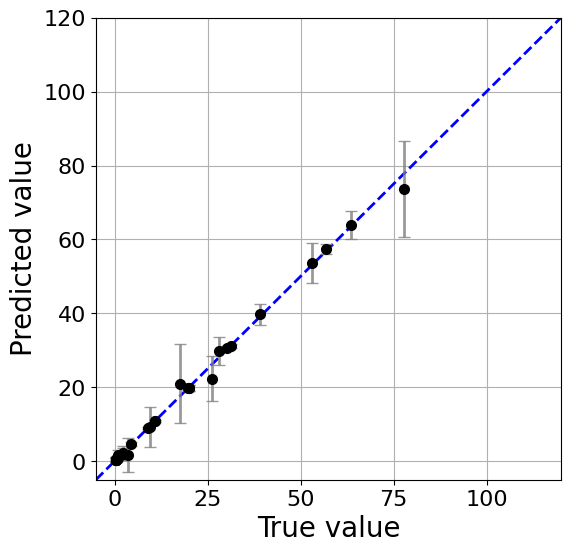

In [11]:
from ax.modelbridge.cross_validation import cross_validate


# Cross-validate model
cv = cross_validate(model)
y_true = np.stack([cv_.observed.data.means for cv_ in cv]).ravel()
y_saas_mean = np.stack([cv_.predicted.means for cv_ in cv]).ravel()
y_saas_std = np.stack(
    [np.sqrt(np.diag(cv_.predicted.covariance)) for cv_ in cv]
).ravel()

# Cross-validation plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
min_val, max_val = -5, 120
ax.plot([min_val, max_val], [min_val, max_val], "b--", lw=2)
markers, caps, bars = ax.errorbar(
    y_true,
    y_saas_mean,
    yerr=1.96 * y_saas_std,
    fmt=".",
    capsize=4,
    elinewidth=2.0,
    ms=14,
    c="k",
    ecolor="gray",
)
[bar.set_alpha(0.8) for bar in bars]
[cap.set_alpha(0.8) for cap in caps]
ax.set_xlim([min_val, max_val])
ax.set_ylim([min_val, max_val])
ax.set_xlabel("True value", fontsize=20)
ax.set_ylabel("Predicted value", fontsize=20)
ax.grid(True)

### Lengthscales
As SAASBO places strong priors on the inverse lengthscales, we only expect parameters 19 and 44 to be identified as important by the model since the other parameters have no effect. We can confirm that this is the case below as the lengthscales of parameters 19 and 44 are close to 1 with all other lengthscales being larger than 1000.  

In [12]:
median_lengthscales = (
    model.model.model.models[0]
    .covar_module.base_kernel.lengthscale.squeeze()
    .median(axis=0)
    .values
)
for i in median_lengthscales.argsort()[:10]:
    print(f"Parameter {i:2}) Median lengthscale = {median_lengthscales[i]:.2e}")

Parameter 19) Median lengthscale = 2.73e-01
Parameter 44) Median lengthscale = 1.47e+00
Parameter 28) Median lengthscale = 4.55e+03
Parameter 23) Median lengthscale = 5.33e+03
Parameter 20) Median lengthscale = 6.01e+03
Parameter 41) Median lengthscale = 6.04e+03
Parameter 37) Median lengthscale = 6.18e+03
Parameter 18) Median lengthscale = 6.27e+03
Parameter 13) Median lengthscale = 6.34e+03
Parameter 34) Median lengthscale = 6.45e+03
